# Machine Learning Engineer Nanodegree
## House Prices: Advanced Regression Techniques

In [107]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

# Visuals and graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load training data
train_raw = pd.read_csv('housing/train.csv')
test_raw = pd.read_csv('housing/test.csv')

# Basic exploration
print("The housing dataset has {} data points with {} variables each.".format(*train_raw.shape))
train_raw.head(10)

The housing dataset has 1460 data points with 81 variables each.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [167]:
# One hot encode data for data analysis
# Remove "NaN" values so our predict() functions
# don't cause errors
encoded_train = pd.get_dummies(train_raw).replace(np.NaN, 0)
encoded_test = pd.get_dummies(test_raw).replace(np.NaN, 0)

# Find top 10 strongest correlations (+/- included)
corr_values = encoded_train.corr().filter(['SalePrice']).drop(['SalePrice'])
corr_values = corr_values.abs()
display(corr_values.sort_values(by=['SalePrice'], ascending=False).head(10))

#encoded_train = encoded_train.drop(['Id'], axis=1)


,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
ExterQual_TA,0.589044
FullBath,0.560664
BsmtQual_Ex,0.553105
TotRmsAbvGrd,0.533723


In [125]:
def detect_outliers(columns, data):
    outliers = []

    for feature in columns:

        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(data[feature], 25)

        Q2 = np.percentile(data[feature], 50)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = (Q3-Q1) * 1.5

        # Display the outliers
        #print "Data points considered outliers for the feature '{}':".format(feature)
        df = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
        #display("{} median: {}".format(feature, Q2))
        #display("{} step: {}".format(feature, step))
        display("{} number found: {}".format(feature, len(df.index.tolist())))
        #display(data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))])
        items = df.Id.tolist()
        outliers.append((feature, items))
    return outliers

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea
SalePrice,1.000000,0.790982,0.708624,0.640409,0.623431
OverallQual,0.790982,1.000000,0.593007,0.600671,0.562022
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.468997
GarageCars,0.640409,0.600671,0.467247,1.000000,0.882475
GarageArea,0.623431,0.562022,0.468997,0.882475,1.000000


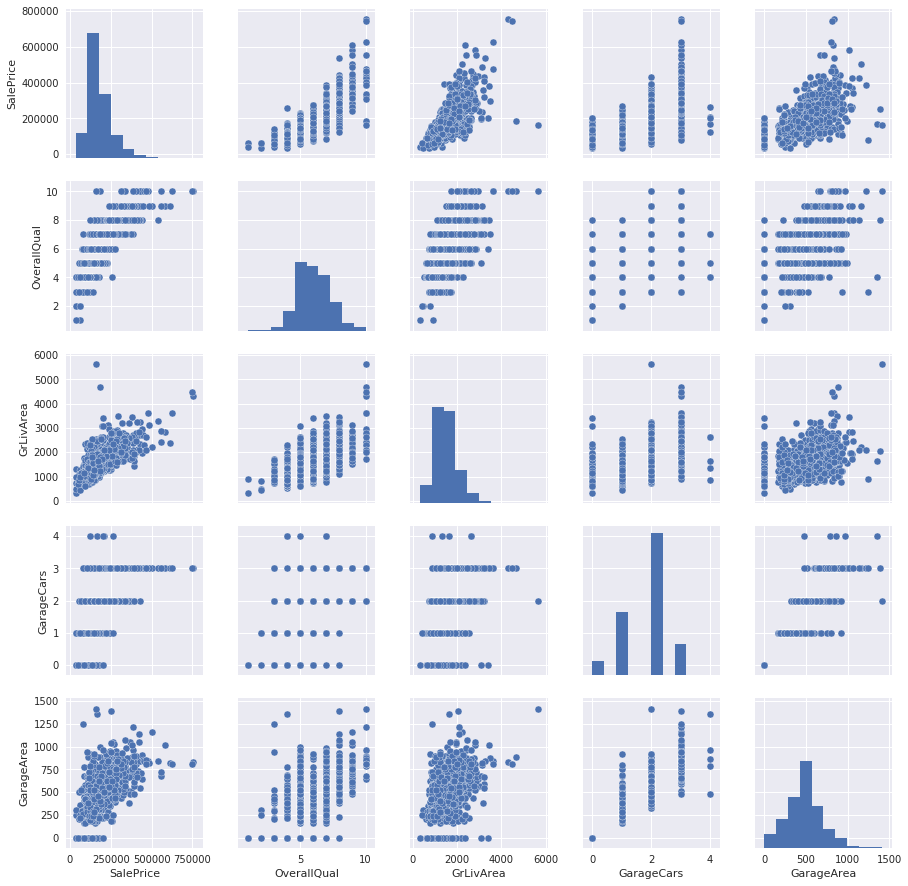

In [110]:
# Let's explore the relationship of these features in relation to our target, SalePrice
# , TotalBsmtSF, 1stFlrSF, ExterQual_TA, FullBath, TotRmsAbvGrd
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea' ]
sns.pairplot(encoded_train[cols], size = 2.5)
display(encoded_train[cols].corr())

,SalePrice,TotalBsmtSF,1stFlrSF,ExterQual_TA,GrLivArea,LotArea
SalePrice,1.000000,0.613581,0.605852,-0.589044,0.689268,0.379446
TotalBsmtSF,0.613581,1.000000,0.819530,-0.390398,0.433093,0.343426
1stFlrSF,0.605852,0.819530,1.000000,-0.312844,0.548186,0.437711
ExterQual_TA,-0.589044,-0.390398,-0.312844,1.000000,-0.396263,-0.061234
GrLivArea,0.689268,0.433093,0.548186,-0.396263,1.000000,0.374635
LotArea,0.379446,0.343426,0.437711,-0.061234,0.374635,1.000000


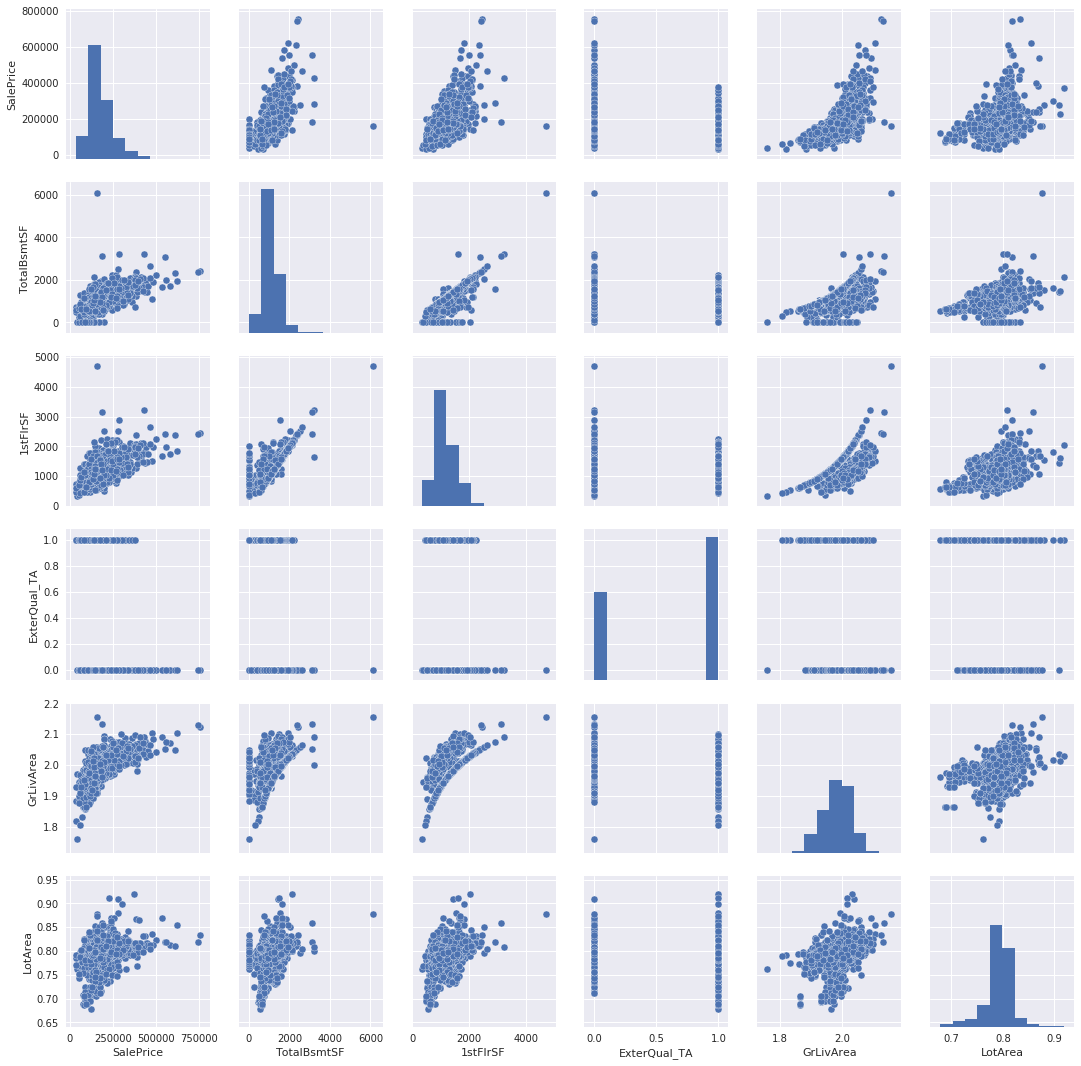

In [162]:
# Let's explore the relationship of these features in relation to our target, SalePrice
sns.set()
encoded_train['LotArea'] = np.log(encoded_train['LotArea'])
encoded_train['GrLivArea'] = np.log(encoded_train['GrLivArea'])
cols = ['SalePrice', 'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'GrLivArea', 'LotArea']
sns.pairplot(encoded_train[cols], size = 2.5)
display(encoded_train[cols].corr())

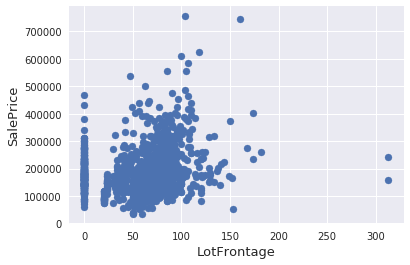

In [156]:
#encoded_data.drop(encoded_data[(encoded_data["GrLivArea"]>4000)&(encoded_data["SalePrice"]<300000)].index,inplace=True)
fig, ax = plt.subplots()
ax.scatter(x = encoded_train['LotFrontage'], y = encoded_train.SalePrice)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()


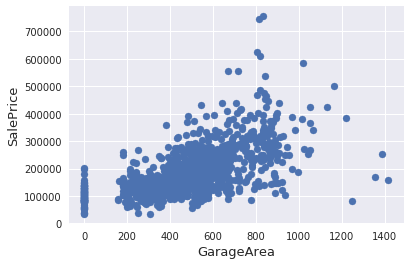

In [113]:
fig, ax = plt.subplots()
ax.scatter(x = encoded_train['GarageArea'], y = encoded_train.SalePrice)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()

In [114]:
from sklearn.metrics import mean_squared_error
import math

def rmlse(y_true, y_pred):
    return (math.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred))))

In [150]:
from sklearn.metrics import r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Initial training
    model[1].fit(X_train, y_train)
    
    # Use the model to make predictions
    y_pred = model[1].predict(X_test)
    score = rmlse(y_test, y_pred)
    #score = r2_score(y_test, y_pred) 
    
    return model, score
    

In [149]:
#df = detect_outliers(['2ndFlrSF','FullBath', 'GarageArea', 'GrLivArea', 'LotArea', 'OverallQual', 'TotalBsmtSF', 
#           'YearBuilt', 'YearRemodAdd', 'YrSold', 'MSZoning_RL'], encoded_train)

#print(df)

In [117]:
encoded_train.fillna(encoded_train.mean(), inplace=True)
encoded_test.fillna(encoded_test.mean(), inplace=True)


In [181]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#columns = ['2ndFlrSF','FullBath', 'GarageArea', 'GrLivArea', 'LotArea', 'OverallQual', 'TotalBsmtSF', 
#           'YearBuilt', 'YrSold', 'MSZoning_RL']
columns = [x for x in encoded_train.columns if x != 'SalePrice' and x in encoded_test.columns]
X = encoded_train[columns]
y = encoded_train.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

models = [('ExtraTreesRegressor', ExtraTreesRegressor(max_depth=8, random_state=0)),
          ('RandomForestRegressor', RandomForestRegressor(max_depth=7, random_state=0)), 
          ('LinearRegression', LinearRegression()), 
          ('Lasso', Lasso(alpha=0.01, max_iter=10000)),
          ('Ridge', Ridge(alpha=.5, normalize=True, random_state=0, max_iter=1000)),
          ('SVR', SVR(C=1.0, epsilon=0.2)),
          ('ElasticNet', ElasticNet(random_state=0, normalize=True)),
          ('XGBRegressor', XGBRegressor())]
models = [('XGBRegressor', XGBRegressor())]
for model in models:
    try:
        model, score = evaluate_model(model, X_train, X_test, y_train, y_test)
    except ValueError:
         print('error', model[0])
    print("{} score: {}".format(model[0], score))

model[1].

predicted_prices = model[1].predict(encoded_test[columns])


XGBRegressor score: 0.133406067068


In [119]:
# XGBRegressor score: 0.133406067068

0.190328264168

In [176]:
my_submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)